In [1]:
using DiffEQ
using Gadfly

In [2]:
type HPParam
    a1::Float64
    a2::Float64
    b1::Float64
    b2::Float64
    d1::Float64
    d2::Float64
end

HPParam(5.0,0.1,0.0,2.0,0.4,0.01)

The default parameters set with $b_1 = 3.0$

In [12]:
param = HPParam(5.0, 0.1, 3.0, 2.0, 0.4, 0.01)

HPParam(5.0,0.1,3.0,2.0,0.4,0.01)

In [10]:
function model(t, y, par::HPParam)
    yprime = zeros(3)
    yprime[1] = y[1]*(1.0 - y[1]) - par.a1*y[1]*y[2]/(1.0 + par.b1*y[1])
    yprime[2] = par.a1*y[1]*y[2]/(1.0 + par.b1*y[1]) - par.a2*y[2]*y[3]/(1.0 + par.b2*y[2]) - par.d1*y[2]
    yprime[3] = par.a2*y[2]*y[3]/(1.0 + par.b2*y[2]) - par.d2*y[3]
    return yprime
end

model (generic function with 1 method)

In [22]:
sol = ode45((t, x) -> model(t, x, param), [0.8, 0.2, 10.0], 0.0:10000);
# small perturburbation to initial conditions
sol_div = ode45((t, x) -> model(t, x, param), [0.81, 0.21, 10.1], 0.0:10000);

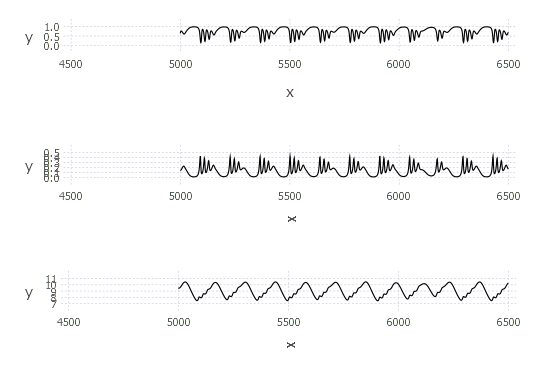

In [20]:
p1 = plot(x = sol.x[5000:6500], y = sol.y[5000:6500, 1], Geom.line, Theme(default_color = colorant"black"));
p2 = plot(x = sol.x[5000:6500], y = sol.y[5000:6500, 2], Geom.line, Theme(default_color = colorant"black"));
p3 = plot(x = sol.x[5000:6500], y = sol.y[5000:6500, 3], Geom.line, Theme(default_color = colorant"black"));
vstack(p1, p2, p3)